In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)




print(torch.__version__, torchvision.__version__)

print (torch.cuda.get_device_name(device='cuda:0'))

2.3.1+cu121 0.9.1+cu111
NVIDIA RTX A5000


In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda


In [3]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)

torch.manual_seed(50)

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def weights_init_dropout(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.1, 0.1)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.1, 0.1)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
                nn.Linear(768, 106)
                 #nn.Dropout(p=0.01)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    

net = LeNet().to(device)
net.apply(weights_init)


# class LeNet_att(nn.Module):
#     def __init__(self):
#         super(LeNet_att, self).__init__()
#         act = nn.Sigmoid
#         #act = nn.Tanh
#         #act = nn.ReLU
#         self.body = nn.Sequential(
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#         )
#         self.fc = nn.Sequential(
#                 nn.Linear(768, 106)
#         )
        
#     def forward(self, x):
#         out = self.body(x)
#         out = out.view(out.size(0), -1)
#         # print(out.size())
#         out = self.fc(out)
#         return out

# net_att = LeNet_att().to(device)
# net_att.apply(weights_init_dropout)
    
#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [4]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=14,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.25)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)



# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
#X_train /= 255.0
#X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)

(2801, 32, 32, 3)
(934, 32, 32, 3)


In [6]:
def init_net(training_round):
    net = LeNet().to(device)
    net.apply(weights_init)
    criterion_train = nn.CrossEntropyLoss()
    optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
    trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)
    iter_ = 0

    for epoch in range(training_round):

        for i,data in enumerate(trainloader,0):

            #if epoch>=1:
            if i==1:
                #break
                iter_=iter_+1
                #print (iter_)
                inputs,label = data

                inputs,label =  Variable(inputs),Variable(label) 

                optimizer_train.zero_grad()


                outputs_benign=net(inputs)
                #outputs_benign = F.softmax(outputs_benign, dim=-1)
                #print (outputs_benign[0])


                loss_benign =  criterion_train(outputs_benign,label)

                #print("loss computed")
                loss_benign.backward()
                #print("loss BP")
                optimizer_train.step()

                #if i%2000==0:
                #torch.save(net.state_dict(),'./LFW_net.pth')  

    total = len(y_test)
    acc =0.0
    for ct in range(total):
        testing_data = tt(testing[ct][0].cpu())
        testing_data1 = tp(testing_data).to(device)
        testing_data2 = testing_data1.view(1, *testing_data1.size())
        y_pred = net(testing_data2)
        predicted = torch.argmax(y_pred)

        if predicted == y_test[ct]:
            acc=acc+1
    accuracy = acc / total
    
    print ('fininshed training')
    print (f"trained for {training_round} round accuracy: {accuracy}")
    return net, criterion_train, optimizer_train, trainloader

net, criterion_train, optimizer_train, train_loader = init_net(9)

fininshed training
trained for 9 round accuracy: 0.14025695931477516


In [15]:

######### honest partipant #########
img_index = 2   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

#plt.imshow(dst_pil)
#plt.axis('off')
#plt.savefig("./orig|inal/lfw_batch_idx_12")



batch =1  #
#idx_m = [20,25,32,33,48,79,84]
#idx_m = [2]
idx_m = []

for s in range(1000):
    if dst_tensor[s][1]==2:   
        idx_m.append(s)
        
        #dst_pil = tt(dst_tensor[s][0].cpu())
        #plt.imshow(dst_pil)
        #plt.axis('off')
        #plt.savefig("./original/lfw_batch_idx_%s"%(len(idx_m)))
        
        if len(idx_m)==batch:
            break
print (idx_m)

def sample_and_calcgrad(idx_m):
    dst_pil = tt(dst_tensor[idx_m[0]][0].cpu())   #use img_index

    gt_data = tp(dst_pil).to(device)
    gt_data = torch.unsqueeze(gt_data,0)

    gt_label = dst_tensor[idx_m[0]][1].long().to(device) #use img_index
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=106)
    for bat in range(batch-1):
                dst_pil = tt(dst_tensor[idx_m[bat+1]][0].cpu())   #use img_index
                tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
                #print(tmp.shape)
                gt_data = torch.cat((gt_data,tmp),0)

                gt_label_tmp = dst_tensor[idx_m[bat+1]][1].long().to(device) #use img_index
                gt_label_tmp = gt_label_tmp.view(1, )
                gt_label = torch.cat((gt_label,gt_label_tmp),0)
                gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)

        #plt.imshow(dst_pil)
        #plt.axis('off')
        #plt.savefig("./original/lfw_batch_idx_%s"%(idx_m[bat]))

        #plt.title("Ground truth image")
        #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


    gt_label = torch.reshape(gt_label,(-1,1))    
    #print (gt_data.shape)
    #print (gt_label.shape)
    #print (gt_onehot_label.shape)
    #print (gt_label)


    # compute original gradient 
    dy_dx = []
    original_dy_dx=[]
    original_pred = []
    # for item in range(batch):
    #     gt_data_single = torch.unsqueeze(gt_data[item],0)
    #     out = net(gt_data_single)
    #     #y = criterion(out, gt_onehot_label[item])
    #     y = criterion(out, gt_label[item])
    #     dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    #     original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    #     original_dy_dx.append(original_dy_dx_tmp)
    #     out_tmp = out.detach().clone()
    #     original_pred.append(out_tmp)


    

    out = net(gt_data)
    #y = criterion(out, gt_onehot_label[item])
    gt_label_batch = torch.squeeze(gt_label,dim=1)
    y = criterion(out, gt_label_batch)
    dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
    out_tmp = out.detach().clone()
    original_pred.append(out_tmp)
    return original_dy_dx, original_pred

    #dy_dx.append(torch.autograd.grad(y, net.parameters()))

original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
    

    
# #FOR fully-connected model only
#     dw = net.body[0].weight
#     db = net.body[0].bias
#     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
#     dy_db = torch.autograd.grad(y, db,retain_graph=True)
#print(original_dy_dx)




# print(original_pred)

#     leak=dy_dw/dy_db

#     print (leak.shape)
    


# share the gradients with other clients
#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


[200]


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
Dummy label is 42.
stolen label is 2.
0.00681927
0.00017570
0.00008123
0.00005404
0.00004039
0.00003412
0.00003061
0.00002613
0.00002397
0.00002153
0.00001946
0.00001821
0.00001673
0.00001600
0.00001528
0.00001450
0.00001355
0.00001304
0.00001259
0.00001231
0.00001139
0.00001133
0.00001062
0.00001029
0.00000970
0.00030420
0.00006581
0.00003718
0.00002704
0.00002180
0.00001853
0.00001640
0.00001539
0.00001349
0.00001281
0.00001202
0.00001113
0.00001083
0.00001057
0.00001053
0.00001000
0.00000

<Figure size 432x288 with 0 Axes>

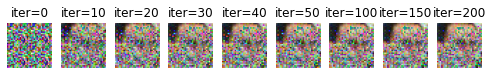

In [16]:
# generate dummy data and label
import time
 
from pytorch_msssim import ssim


#print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
#print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())

for item in range(1):
    start = time.perf_counter()
    for rd in range(1):

        torch.manual_seed(100*rd)
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        #dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        #dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

        
        #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
        #background[0,2,::] = 1
        #dummy_data = background.to(device).requires_grad_(True)
        #dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
        
        #surrogate = torch.unsqueeze(gt_data[item+1],0)
        #aaa = torch.rand([3,16,16])
        #surrogate[0,:,8:24,8:24] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)    
        
        #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
        
        #k = np.random.randint(0,95)
        #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        
        pat_1 = torch.rand([3,16,16])
        pat_2 = torch.cat((pat_1,pat_1),dim=1)
        pat_4 = torch.cat((pat_2,pat_2),dim=2)
        dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
        
        
        dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
        print(dummy_unsqueeze)
        
        dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
        label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                dim=-1).detach().reshape((1,)).requires_grad_(False)
        #print (original_dy_dx[item][-1].shape)
        #print (original_dy_dx[item][-1].argmin())
        
        #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        
        optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
        #optimizer = torch.optim.LBFGS([dummy_data,])
        #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)

        history = []
        
        percept_dis = np.zeros(300)
        recover_dis = np.zeros(300)
        for iters in range(300):
            
          
            percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
            recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
           
            history.append(tt(dummy_data[0].cpu()))
            def closure():
                optimizer.zero_grad()

                pred = net(dummy_data) 

                dummy_loss = criterion(pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

                grad_diff = 0
                grad_count = 0
                #count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                    grad_count += gx.nelement()

                grad_diff.backward()
                


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())

        
        
        #plt.figure(figsize=(18, 12))
        #for i in range(60):
        #  plt.subplot(6, 10, i + 1)
        #  plt.imshow(history[i * 5])
        #  plt.title("iter=%d" % (i * 5))
        #  plt.axis('off')
        
        
        plt.figure(figsize=(8.5, 1.2))
        iter_idx = [0,10,20,30,40,50,100,150,200]
        for i in range(9):
          plt.subplot(1, 9, i + 1)
          plt.imshow(history[iter_idx[i]])
          plt.title("iter=%d" % (iter_idx[i]))
          plt.axis('off')
            
        #np.savetxt('ssim_random_batch8',percept_dis,fmt="%4f")
        #np.savetxt('mse_random_batch8',recover_dis,fmt="%4f")
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
        #plt.clf()
       
    duration = time.perf_counter()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    
        

Dummy label is 42.


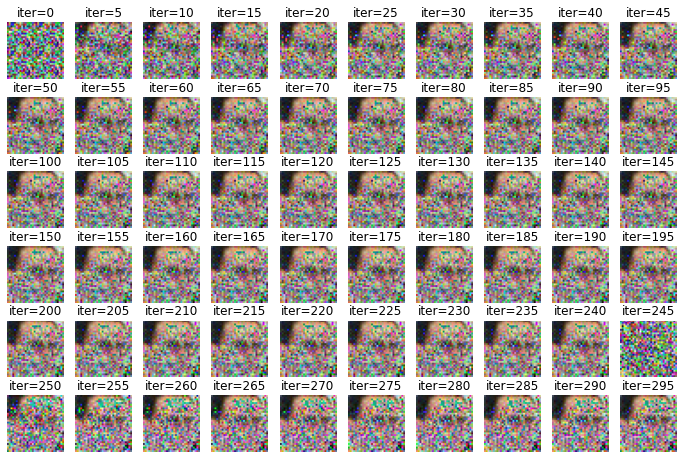

In [17]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [9]:
def CPL(original_dy_dx, threshhold=0.0001, seed=0):
    for item in range(1):
        start = time.perf_counter()
        for rd in range(1):

            torch.manual_seed(seed)


            pat_1 = torch.rand([3,16,16])
            pat_2 = torch.cat((pat_1,pat_1),dim=1)
            pat_4 = torch.cat((pat_2,pat_2),dim=2)
            dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)


            dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)

            dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
            label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                    dim=-1).detach().reshape((1,)).requires_grad_(False)


            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title("Dummy data")

            plt.clf()
            print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
            print("stolen label is %d." % label_pred.item())


            optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
            #optimizer = torch.optim.LBFGS([dummy_data,],lr=1)
            #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)

            history = []

            percept_dis = np.zeros(300)
            recover_dis = np.zeros(300)
            
            success_iter = 0
            for iters in range(300):


                percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
                recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()

                history.append(tt(dummy_data[0].cpu()))
                def closure():
                    optimizer.zero_grad()

                    pred = net(dummy_data) 
                    dummy_onehot_label = F.softmax(dummy_label, dim=-1).float()

                    dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                    #print (pred)
                    #print (label_pred)

                    #dummy_loss = criterion(pred, label_pred)
                    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                    #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                    #print (dummy_dy_dp[0].shape)  

                    grad_diff = 0
                    grad_count = 0
                    #count =0
                    for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                        lasso = torch.norm(dummy_data,p=1)
                        ridge = torch.norm(dummy_data,p=2)
                        grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                        grad_count += gx.nelement()

                    grad_diff.backward()

                    return grad_diff
                optimizer.step(closure)
                current_loss = closure()
                if current_loss <= threshhold:
                    print("%.8f" % current_loss.item())
                    print(f"success at {iters} round")
                    success_iter = iters
                    break
                if iters % 100 == 0: 
                    #if iters == 0: 
                    print ("%.8f" % current_loss.item())
                    #print(iters, "%.8f" % current_loss.item())
                history.append(tt(dummy_data[0].cpu()))

        duration = time.perf_counter()-start
        #print ("Running time is %.4f." %(duration/10.0) )
        print (duration/10.0 )
        return success_iter, history

In [10]:
def CPL_IDLG(original_dy_dx, threshhold=0.0001, seed=0):
    for item in range(1):
        start = time.perf_counter()
        for rd in range(1):

            torch.manual_seed(seed)


            pat_1 = torch.rand([3,16,16])
            pat_2 = torch.cat((pat_1,pat_1),dim=1)
            pat_4 = torch.cat((pat_2,pat_2),dim=2)
            dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)


            dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)

            dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
            label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                    dim=-1).detach().reshape((1,)).requires_grad_(False)


            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title("Dummy data")

            plt.clf()
            print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
            print("stolen label is %d." % label_pred.item())


            #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
            optimizer = torch.optim.LBFGS([dummy_data,],lr=1)
            #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)

            history = []

            percept_dis = np.zeros(300)
            recover_dis = np.zeros(300)
            
            success_iter = 0
            for iters in range(300):


                percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
                recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()

                history.append(tt(dummy_data[0].cpu()))
                def closure():
                    optimizer.zero_grad()

                    pred = net(dummy_data) 
                    #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()

                    #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                    #print (pred)
                    #print (label_pred)

                    dummy_loss = criterion(pred, label_pred)
                    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                    #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                    #print (dummy_dy_dp[0].shape)  

                    grad_diff = 0
                    grad_count = 0
                    #count =0
                    for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                        lasso = torch.norm(dummy_data,p=1)
                        ridge = torch.norm(dummy_data,p=2)
                        grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                        grad_count += gx.nelement()

                    grad_diff.backward()

                    return grad_diff
                optimizer.step(closure)
                current_loss = closure()
                if current_loss <= threshhold:
                    print("%.8f" % current_loss.item())
                    print(f"success at {iters} round")
                    success_iter = iters
                    break
                if iters % 100 == 0: 
                    #if iters == 0: 
                    print ("%.8f" % current_loss.item())
                    #print(iters, "%.8f" % current_loss.item())
                history.append(tt(dummy_data[0].cpu()))

        duration = time.perf_counter()-start
        #print ("Running time is %.4f." %(duration/10.0) )
        print (duration/10.0 )
        return success_iter, history

In [11]:
threshhold = 0.0001
batch = 8
labels = [1, 2, 6, 7, 8, 9, 14, 16, 21, 25, 26, 27, 47]
history_list = []
success_num = 0
attack_iter_sum = 0
seed_num = 3
for label in labels:
    idx_m = []

    for s in range(1000):
        if dst_tensor[s][1]==label:   
            idx_m.append(s)
        if len(idx_m)==batch:
            break
    
    original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
    history_tmp = []
    for seed in range(seed_num):
        success_iter, history = CPL_IDLG(original_dy_dx, threshhold=threshhold, seed=seed)
        if success_iter:
            success_num += 1
            attack_iter_sum += success_iter
        history_tmp.append(history)
    history_list.append(history_tmp)


print(f"ASR is {success_num / (len(labels)*seed_num)}")
print(f"attack iter is {attack_iter_sum / success_num}")

Dummy label is 42.
stolen label is 1.
0.01151613
0.00009944
success at 28 round
0.7634744447655976
Dummy label is 43.
stolen label is 1.
0.01050865
0.00009907
success at 31 round
0.8323001211043447
Dummy label is 79.
stolen label is 1.
0.01104268
0.00009720
success at 29 round
0.7742676943074912
Dummy label is 42.
stolen label is 2.
0.00850995
0.00009827
success at 39 round
1.0620339777786285
Dummy label is 43.
stolen label is 2.
0.00788356
0.00009912
success at 35 round
0.9483131908811628
Dummy label is 79.
stolen label is 2.
0.00755295
0.00009892
success at 36 round
0.9687281017191708
Dummy label is 42.
stolen label is 6.
0.01840142
0.00009931
success at 40 round
1.083352975314483
Dummy label is 43.
stolen label is 6.
0.01553052
0.00009793
success at 34 round
0.9237901946064084
Dummy label is 79.
stolen label is 6.
0.01635280
0.00009946
success at 34 round
0.9095290367957205
Dummy label is 42.
stolen label is 7.
0.00818918
0.00009866
success at 27 round
0.7170311002060771
Dummy label

<Figure size 432x288 with 0 Axes>

In [12]:
threshhold = 0.0001
batch = 8
labels = [1, 2, 6, 7, 8, 9, 14, 16, 21, 25, 26, 27, 47]
history_list = []
success_num = 0
attack_iter_sum = 0
seed_num = 3
idlg = False
for label in labels:
    idx_m = []

    for s in range(1000):
        if dst_tensor[s][1]==label:   
            idx_m.append(s)
        if len(idx_m)==batch:
            break
    
    original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
    history_tmp = []
    for seed in range(seed_num):
        if idlg:
            success_iter, history = CPL_IDLG(original_dy_dx, threshhold=threshhold, seed=seed)
        else:
            success_iter, history = CPL(original_dy_dx, threshhold=threshhold, seed=seed)
        if success_iter:
            success_num += 1
            attack_iter_sum += success_iter
        history_tmp.append(history)
    history_list.append(history_tmp)


print(f"ASR is {success_num / (len(labels)*seed_num)}")
print(f"attack iter is {attack_iter_sum / success_num}")



Dummy label is 42.
stolen label is 1.
0.01369754
0.00009941
success at 29 round
0.787986615113914
Dummy label is 43.
stolen label is 1.
0.01444670
0.00009950
success at 31 round
0.843480303324759
Dummy label is 79.
stolen label is 1.
0.01373337
0.00009776
success at 29 round
0.778472181968391
Dummy label is 42.
stolen label is 2.
0.00961116
0.00009879
success at 39 round
1.0580749813932926
Dummy label is 43.
stolen label is 2.
0.01644221
0.00009914
success at 37 round
1.0145393398124725
Dummy label is 79.
stolen label is 2.
293.66168213
14.05787182
14.05787182
0.33899740600027145
Dummy label is 42.
stolen label is 6.
0.25699833
0.00009809
success at 39 round
1.0657907037064434
Dummy label is 43.
stolen label is 6.
280.40054321
437.80307007
437.80307007
0.3698196713346988
Dummy label is 79.
stolen label is 6.
0.02229070
0.00009829
success at 36 round
0.9734511252027005
Dummy label is 42.
stolen label is 7.
4.31270170
553.97790527
553.97790527
0.489748097024858
Dummy label is 43.
stolen 

<Figure size 432x288 with 0 Axes>

In [ ]:
threshhold = 0.0001
batch = 8
labels = [1, 2, 6, 7, 8, 9, 14, 16, 21, 25, 26, 27, 47]
seed_num = 5
idlg = False
training_rounds = [8,8,8,8,8, 9, 9, 9,9,9]
ASR = []
attack_iter = []
for tr in training_rounds:
    net, criterion_train, optimizer_train, train_loader = init_net(tr)
    history_list = []
    success_num = 0
    attack_iter_sum = 0
    for label in labels:
        idx_m = []

        for s in range(1000):
            if dst_tensor[s][1]==label:   
                idx_m.append(s)
            if len(idx_m)==batch:
                break

        original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
        history_tmp = []
        for seed in range(seed_num):
            if idlg:
                success_iter, history = CPL_IDLG(original_dy_dx, threshhold=threshhold, seed=seed)
            else:
                success_iter, history = CPL(original_dy_dx, threshhold=threshhold, seed=seed)
            if success_iter:
                success_num += 1
                attack_iter_sum += success_iter
            history_tmp.append(history)
        history_list.append(history_tmp)
    if success_num == 0:
        asr_ = 0
        attack_iter_ = 300
    else:
        asr_ = success_num / (len(labels)*seed_num)
        attack_iter_ = attack_iter_sum / success_num
    ASR.append(asr_)
    attack_iter.append(attack_iter_)
    print("finished attack")
    print(f"{tr} training rounds")
    print(f"ASR is {asr_}")
    print(f"attack iter is {attack_iter_}")

fininshed training
trained for 8 round accuracy: 0.14025695931477516
Dummy label is 42.
stolen label is 1.
0.01017086
0.00009591
success at 19 round
0.5225218097213655
Dummy label is 43.
stolen label is 1.
0.09927154
0.00009611
success at 22 round
0.6558030990883708
Dummy label is 79.
stolen label is 1.
0.01189421
0.00009956
success at 18 round
0.5001634488813579
Dummy label is 1.
stolen label is 1.
0.00957802
0.00009683
success at 19 round
0.5583540148101747
Dummy label is 105.
stolen label is 1.
37.82698441
51.48552322
51.48552322
0.378043399611488
Dummy label is 42.
stolen label is 2.
0.00619234
0.00009647
success at 18 round
0.4460005661007017
Dummy label is 43.
stolen label is 2.
0.07592847
0.00009954
success at 21 round
0.5343533557839691
Dummy label is 79.
stolen label is 2.
0.07366867
0.00009990
success at 19 round
0.4702950682956725
Dummy label is 1.
stolen label is 2.
40.58360672
78.84188080
78.84188080
0.3482700258027762
Dummy label is 105.
stolen label is 2.
43.86142349
155

0.07923254
0.00009957
success at 20 round
0.5781115635298193
Dummy label is 79.
stolen label is 7.
0.14307591
0.00009829
success at 20 round
0.5785134887788445
Dummy label is 1.
stolen label is 7.
0.00889673
0.00009799
success at 17 round
0.42974505489692094
Dummy label is 105.
stolen label is 7.
0.34996152
0.00009958
success at 42 round
1.0856434354092925
Dummy label is 42.
stolen label is 8.
0.02323079
0.00009640
success at 14 round
0.38746444657444956
Dummy label is 43.
stolen label is 8.
0.01798986
0.00009420
success at 14 round
0.37728865602985023
Dummy label is 79.
stolen label is 8.
0.00590187
0.00009946
success at 13 round
0.33833493357524275
Dummy label is 1.
stolen label is 8.
0.00617485
0.00009530
success at 12 round
0.34218687838874756
Dummy label is 105.
stolen label is 8.
0.43212500
0.00009953
success at 23 round
0.6258631336037069
Dummy label is 42.
stolen label is 9.
1.44265079
2.64251351
2.64251351
0.3831946496386081
Dummy label is 43.
stolen label is 9.
0.01000732
0.0

0.01174778
0.00009822
success at 23 round
0.7132757676765322
Dummy label is 42.
stolen label is 16.
0.00653568
0.00009947
success at 24 round
0.7940056330990046
Dummy label is 43.
stolen label is 16.
51.80950165
56.83145523
56.83145523
0.7623247841373086
Dummy label is 79.
stolen label is 16.
0.01841790
0.00009996
success at 24 round
0.7520375520922243
Dummy label is 1.
stolen label is 16.
0.01274605
0.00009905
success at 24 round
0.8494610331952572
Dummy label is 105.
stolen label is 16.
0.01115065
0.00009827
success at 28 round
0.754448056127876
Dummy label is 42.
stolen label is 21.
0.01860217
0.00009661
success at 20 round
0.6560854518786072
Dummy label is 43.
stolen label is 21.
0.03932260
0.00009500
success at 20 round
0.5816081373952329
Dummy label is 79.
stolen label is 21.
0.08119158
0.00009843
success at 28 round
0.8403345210943372
Dummy label is 1.
stolen label is 21.
38.55220032
53.66220856
53.66220856
0.8842845033854246
Dummy label is 105.
stolen label is 21.
50.47510910
6

61.40736771
0.37552691539749505
Dummy label is 79.
stolen label is 26.
26.74864197
90.31758881
90.31758881
1.0372177189216019
Dummy label is 1.
stolen label is 26.
41.14050674
64.01290131
64.01290131
1.2492478819098323
Dummy label is 105.
stolen label is 26.
0.00875925
0.00009690
success at 20 round
0.517230541491881
Dummy label is 42.
stolen label is 27.
0.01344950
0.00009909
success at 18 round
0.43531413772143424
Dummy label is 43.
stolen label is 27.
0.05714301
0.00009936
success at 19 round
0.5170709376223386
Dummy label is 79.
stolen label is 27.
0.01141068
0.00009656
success at 18 round
0.4913697096053511
Dummy label is 1.
stolen label is 27.
0.05096609
0.00009922
success at 19 round
0.5146559777669608
Dummy label is 105.
stolen label is 27.
0.05560854
0.00009745
success at 19 round
0.5432202657684684
Dummy label is 42.
stolen label is 47.
0.01756920
0.00009954
success at 13 round
0.3776725263800472
Dummy label is 43.
stolen label is 47.
54.44908142
53.55054092
53.55054092
0.399

0.00009497
success at 9 round
0.2160682796034962
Dummy label is 1.
stolen label is 1.
0.00514865
0.00009582
success at 9 round
0.28128521163016557
Dummy label is 105.
stolen label is 1.
35.01405716
43.35607910
43.35607910
0.7399492642842234
Dummy label is 42.
stolen label is 2.
0.00352934
0.00009586
success at 8 round
0.18898636531084775
Dummy label is 43.
stolen label is 2.
51.94118500
5.04249954
5.04249954
0.3728930181823671
Dummy label is 79.
stolen label is 2.
0.01757577
0.00009825
success at 8 round
0.18819850888103246
Dummy label is 1.
stolen label is 2.
29.12997055
39.22092056
39.22092056
0.37989997430704536
Dummy label is 105.
stolen label is 2.
31.25284195
48.86013794
48.86013794
0.5529610364697873
Dummy label is 42.
stolen label is 6.
35.52670288
0.00009681
success at 22 round
0.5523381155915559
Dummy label is 43.
stolen label is 6.
13.18380547
52.79703522
52.79703522
0.3446128901094198
Dummy label is 79.
stolen label is 6.
0.00614847
0.00009670
success at 9 round
0.219482620

0.00009792
success at 7 round
0.1802537236828357
Dummy label is 43.
stolen label is 8.
0.04318821
0.00009835
success at 13 round
0.33950588321313263
Dummy label is 79.
stolen label is 8.
0.00410083
0.00009986
success at 7 round
0.17155736703425645
Dummy label is 1.
stolen label is 8.
0.00418222
0.00009228
success at 7 round
0.2327681434340775
Dummy label is 105.
stolen label is 8.
13.49328136
1.74902320
1.74902320
0.8483488284982741
Dummy label is 42.
stolen label is 9.
0.08510809
0.00009983
success at 61 round
1.9094889873173089
Dummy label is 43.
stolen label is 9.
0.00434334
0.00009218
success at 10 round
0.33371516591869294
Dummy label is 79.
stolen label is 9.
0.11158533
0.00009796
success at 12 round
0.3976480427198112
Dummy label is 1.
stolen label is 9.
26.35628510
50.83014679
50.83014679
0.7477209458127618
Dummy label is 105.
stolen label is 9.
0.06924757
0.00009903
success at 30 round
0.8371595366857946
Dummy label is 42.
stolen label is 14.
0.00630067
0.00009760
success at 1

0.00009422
success at 12 round
0.3119959625881165
Dummy label is 1.
stolen label is 16.
0.00364898
0.00009704
success at 10 round
0.2600572624243796
Dummy label is 105.
stolen label is 16.
0.02649905
0.00009922
success at 11 round
0.2933360288850963
Dummy label is 42.
stolen label is 21.
0.00274435
0.00009644
success at 8 round
0.19461725461296736
Dummy label is 43.
stolen label is 21.
0.01698018
0.00009059
success at 9 round
0.22357988101430237
Dummy label is 79.
stolen label is 21.
0.00383260
0.00009390
success at 7 round
0.16740156128071249
Dummy label is 1.
stolen label is 21.
21.13296700
56.47012329
56.47012329
0.6135858832392842
Dummy label is 105.
stolen label is 21.
0.01949569
0.00009237
success at 10 round
0.24825569400563835
Dummy label is 42.
stolen label is 25.
0.00820921
0.00008811
success at 9 round
0.22287116590887307
Dummy label is 43.
stolen label is 25.
29.46269608
75.06808472
75.06808472
0.3024685238022357
Dummy label is 79.
stolen label is 25.
27.09674072
101.675392

0.00493601
0.00009542
success at 10 round
0.332313278876245
Dummy label is 43.
stolen label is 27.
0.01874951
0.00009500
success at 11 round
0.3062768431380391
Dummy label is 79.
stolen label is 27.
0.00448586
0.00009352
success at 10 round
0.24368941970169544
Dummy label is 1.
stolen label is 27.
0.52809536
95.75094604
95.75094604
0.32999252625741066
Dummy label is 105.
stolen label is 27.
0.03095772
0.00009877
success at 11 round
0.26984914047643543
Dummy label is 42.
stolen label is 47.
0.05236803
0.00009428
success at 12 round
0.34797816118225455
Dummy label is 43.
stolen label is 47.
22.42002106
37.47343445
37.47343445
1.2241474659182132
Dummy label is 79.
stolen label is 47.
26.53065109
39.85277557
39.85277557
1.1211298326961696
Dummy label is 1.
stolen label is 47.
0.00921973
0.00009113
success at 7 round
0.20683234729804098
Dummy label is 105.
stolen label is 47.
0.05295115
0.00009922
success at 21 round
0.5319309316109866
finished attack
9 training rounds
ASR is 0.723076923076

In [ ]:
print(training_rounds)
print(ASR)
print(attack_iter)

IndexError: list index out of range

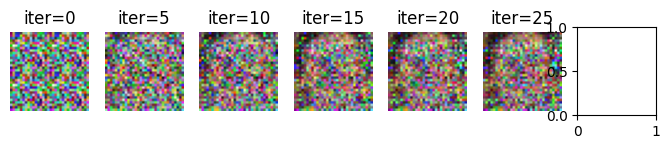

In [15]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history_list[0][0][i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())